In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from math import sqrt

import numpy as np
import pandas as pd
import requests
import json
import csv
import io

In [2]:
# Constants
CASES_URL = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv'
DEATHS_URL = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_deaths_usafacts.csv'
POPS_URL = 'https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv'

## Get the Data

In [3]:
# update_data -> None
# updates the cases, deaths, and pops json files to have the most recent data from usafacts.org.
def update_data():
    
    # Get Cases
    cases_data = {}
    cases_r = requests.get(CASES_URL)
    cases_reader = csv.DictReader(io.StringIO(cases_r.text))
    
    for rows in cases_reader:
        idx = list(rows.keys())[0]
        key = rows[idx]
        cases_data[key] = rows
        
    with open('cases.json', 'w', encoding='utf-8') as jsonf:
        jsonf.write(json.dumps(cases_data, indent=4))
        
    # Get Deaths
    deaths_data = {}
    deaths_r = requests.get(DEATHS_URL)
    deaths_reader = csv.DictReader(io.StringIO(deaths_r.text))
    
    for rows in deaths_reader:
        idx = list(rows.keys())[0]
        key = rows[idx]
        deaths_data[key] = rows
        
    with open('deaths.json', 'w', encoding='utf-8') as jsonf:
        jsonf.write(json.dumps(deaths_data, indent=4))
        
    # Get Populations
    pops_data = {}
    pops_r = requests.get(POPS_URL)
    pops_reader = csv.DictReader(io.StringIO(pops_r.text))
    
    for rows in pops_reader:
        idx = list(rows.keys())[0]
        key = rows[idx]
        pops_data[key] = rows
        
    with open('pops.json', 'w', encoding='utf-8') as jsonf:
        jsonf.write(json.dumps(pops_data, indent=4))
    
update_data()

In [4]:
# get_dataframes -> (DataFrame, DataFrame, DataFrame)
# reads the cases, deaths, and populations json files in and converts them to pandas dataframes.
def get_dataframes():
    cases_df = ''
    deaths_df = ''
    pops_df = ''

    with open('cases.json') as file:
        cases_data = json.load(file)
        cases_df = pd.DataFrame(cases_data).transpose()
    
    with open('deaths.json') as file:
        deaths_data = json.load(file)
        deaths_df = pd.DataFrame(deaths_data).transpose()
        
    with open('pops.json') as file:
        pops_data = json.load(file)
        pops_df = pd.DataFrame(pops_data).transpose()
        
    return (cases_df, deaths_df, pops_df)
        
    
cases_df, deaths_df, pops_df = get_dataframes()

## Preprocessing

In [5]:
# new_cases -> DataFrame
# Calculates the number of new cases in a given day based on the previous day's value and replaces the corresponding
# cell with that value.
def new_cases():
    df = cases_df.copy()
    ignored_columns = [0, 1, 2, 3, 4]
    num_cols = len(df.columns)
    
    for index, row in df.iterrows():
        for col_idx in reversed(range(num_cols)):
            if col_idx not in ignored_columns:
                curr_col = df.columns[col_idx]
                last_col = df.columns[col_idx-1]
                df.at[index, curr_col] = int(df.at[index, curr_col]) - int(df.at[index, last_col])
                
    return df

new_cases_df = new_cases()
new_cases_df

,﻿countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20
0,0,Statewide Unallocated,WY,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,1001,Autauga County,AL,1,0,0,0,0,0,0,...,17,17,6,10,11,11,2,7,18,11
1003,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,48,17,19,6,30,38,32,140,22,21
1005,1005,Barbour County,AL,1,0,0,0,0,0,0,...,3,9,4,0,7,8,1,15,19,2
1007,1007,Bibb County,AL,1,0,0,0,0,0,0,...,10,4,10,4,2,10,10,14,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,56037,Sweetwater County,WY,56,0,0,0,0,0,0,...,4,1,4,7,6,8,7,8,5,6
56039,56039,Teton County,WY,56,0,0,0,0,0,0,...,5,0,8,11,4,0,12,13,3,4
56041,56041,Uinta County,WY,56,0,0,0,0,0,0,...,4,9,0,2,1,3,3,15,3,3
56043,56043,Washakie County,WY,56,0,0,0,0,0,0,...,1,0,1,1,4,3,1,1,1,0


In [6]:
# new_deaths -> DataFrame
# Calculates the number of new deaths in a given day based on the previous day's value and replaces the corresponding
# cell with that value.
def new_deaths():
    df = deaths_df.copy()
    ignored_columns = [0, 1, 2, 3, 4]
    num_cols = len(df.columns)
    
    for index, row in df.iterrows():
        for col_idx in reversed(range(num_cols)):
            if col_idx not in ignored_columns:
                curr_col = df.columns[col_idx]
                last_col = df.columns[col_idx-1]
                df.at[index, curr_col] = int(df.at[index, curr_col]) - int(df.at[index, last_col])
                
    return df

new_deaths_df = new_deaths()
new_deaths_df

,﻿countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20
0,0,Statewide Unallocated,WY,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,1001,Autauga County,AL,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
1003,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,1,0,0,0,2,0,0,0,0,0
1005,1005,Barbour County,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1007,1007,Bibb County,AL,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,56037,Sweetwater County,WY,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56039,56039,Teton County,WY,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56041,56041,Uinta County,WY,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
56043,56043,Washakie County,WY,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# master_dataframe -> DataFrame
# Creates a new dataframe with the following specifications (to be used in model training):
# Columns: [CountyFIPS, Population, Total Cases, New Cases, Total Deaths, New Deaths, Cases in 7 Days]
# Index: [Date]
def master_dataframe():
    c_df = cases_df.copy().iloc[:,:-7]
    d_df = deaths_df.copy().iloc[:,:-7]
    n_c_df = new_cases_df.copy().iloc[:,:-7]
    n_d_df = new_deaths_df.copy().iloc[:,:-7]
    
    dates = []
    counties = []
    populations = []
    total_cases = []
    new_cases = []
    total_deaths = []
    new_deaths = []
    num_cases_in_seven_days = []
    ignored_columns = [0, 1, 2, 3]
    
    row_index = 0
    for index, row in c_df.iterrows():
        countyFIPS = c_df.at[index, c_df.columns[0]]
        if countyFIPS in pops_df['ï»¿countyFIPS']:
            population = pops_df.loc[pops_df['ï»¿countyFIPS'] == countyFIPS, 'population'].iloc[0]
        else:
            population = 0
        
        for col_idx in range(len(c_df.columns)):
            if col_idx not in ignored_columns:
                date = cases_df.columns[col_idx]
                dates.append(date)
                counties.append(countyFIPS)
                populations.append(population)
                total_cases.append(c_df.iloc[int(row_index)][date])
                new_cases.append(n_c_df.iloc[int(row_index)][date])
                total_deaths.append(d_df.iloc[int(row_index)][date])
                new_deaths.append(n_d_df.iloc[int(row_index)][date])
                num_cases_in_seven_days.append(cases_df.iloc[int(row_index)][cases_df.columns[col_idx + 7]])
        row_index += 1
        
    df = pd.DataFrame(list(zip(counties, populations, total_cases, new_cases, total_deaths, new_deaths, num_cases_in_seven_days)), 
                      index = dates, 
                      columns = ['CountyFIPS', 'Population', 'Total Cases', 'New Cases', 'Total Deaths', 'New Deaths', 'Cases in 7 Days'])
    return df
    
master_df = master_dataframe()
master_df

,CountyFIPS,Population,Total Cases,New Cases,Total Deaths,New Deaths,Cases in 7 Days
1/22/20,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
10/14/20,56045,6927,66,4,0,0,103
10/15/20,56045,6927,71,5,0,0,115
10/16/20,56045,6927,81,10,0,0,121
10/17/20,56045,6927,88,7,0,0,127


## Visualizing the Data

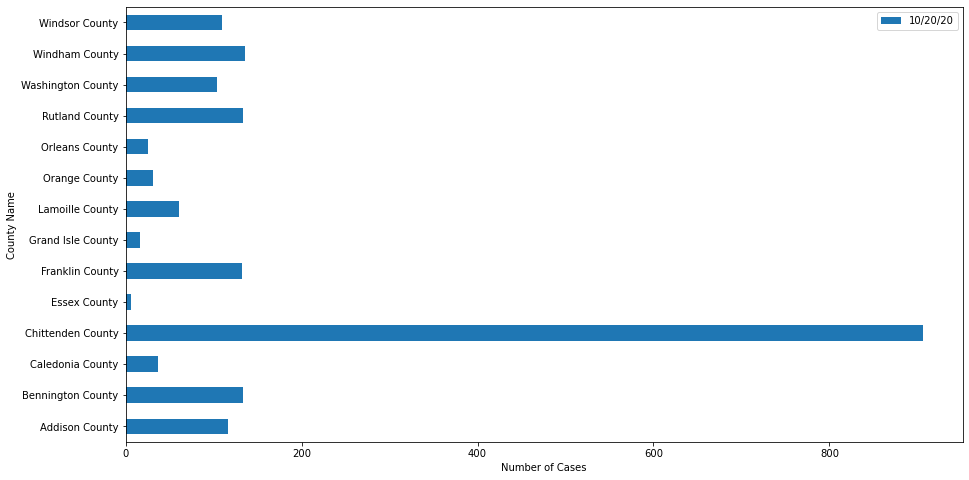

In [8]:
# cases_bar_graph_by_state_by_date -> None
# Takes a state and a list of dates as input and creates a bar graph of 
# the number of cases per county in the given state for the given dates.
def cases_bar_graph_by_state_by_date(state, dates):
    graphing_df = cases_df.copy()
    graphing_df = graphing_df.loc[graphing_df['State'] == state]
    for date in dates:
        graphing_df[date] = graphing_df[date].astype(int)
    
    ax = graphing_df.plot.barh(x='County Name', y=dates, figsize=(15,8)).set(xlabel='Number of Cases')
    
cases_bar_graph_by_state_by_date('VT', ['10/20/20'])

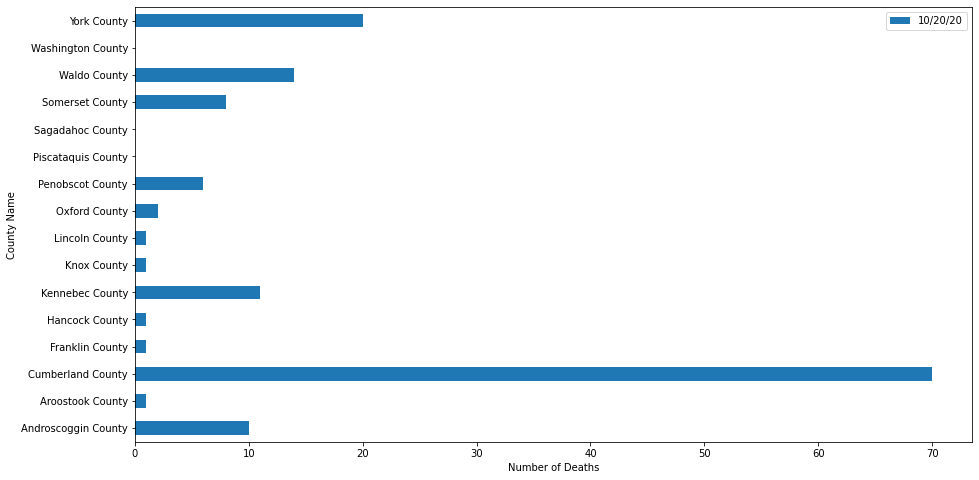

In [9]:
# deaths_bar_graph_by_state_by_date -> None
# Takes a state and a list of dates as input and creates a bar graph of 
# the number of deaths per county in the given state for the given dates.
def deaths_bar_graph_by_state_by_date(state, date):
    graphing_df = deaths_df.copy()
    graphing_df = graphing_df.loc[graphing_df['State'] == state]
    graphing_df[date] = graphing_df[date].astype(int)
    
    ax = graphing_df.plot.barh(x='County Name', y=date, figsize=(15,8)).set(xlabel='Number of Deaths')
    
deaths_bar_graph_by_state_by_date('ME', '10/20/20')

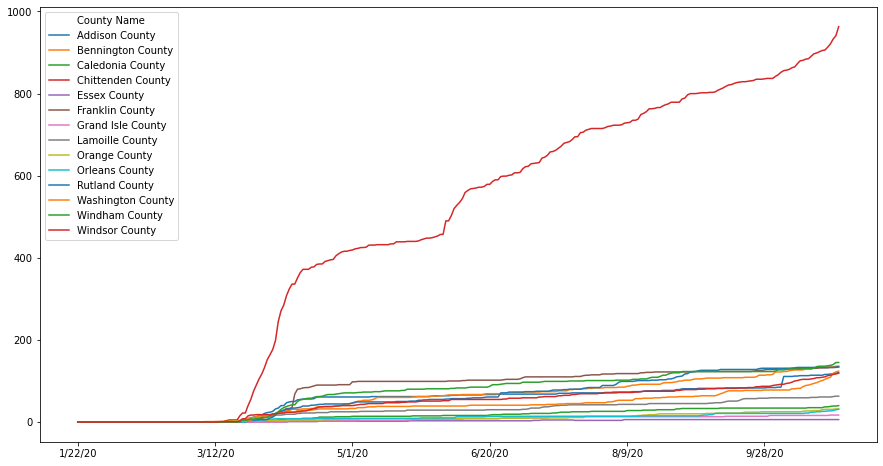

In [10]:
# cases_by_state -> None
# Takes a state and generates a line graph that shows the number of cases for each
# county in that state over the entire date range.
def cases_by_state(state):
    graphing_df = cases_df.copy()
    graphing_df = graphing_df.set_index('County Name')
    graphing_df = graphing_df.loc[graphing_df['State'] == state]
    graphing_df = graphing_df.drop(columns=graphing_df.columns[[0,1,2]])
    
    for column in graphing_df:
        graphing_df[column] = graphing_df[column].astype(int)
        
    graphing_df.transpose().plot(figsize=(15,8))
    
cases_by_state('VT')

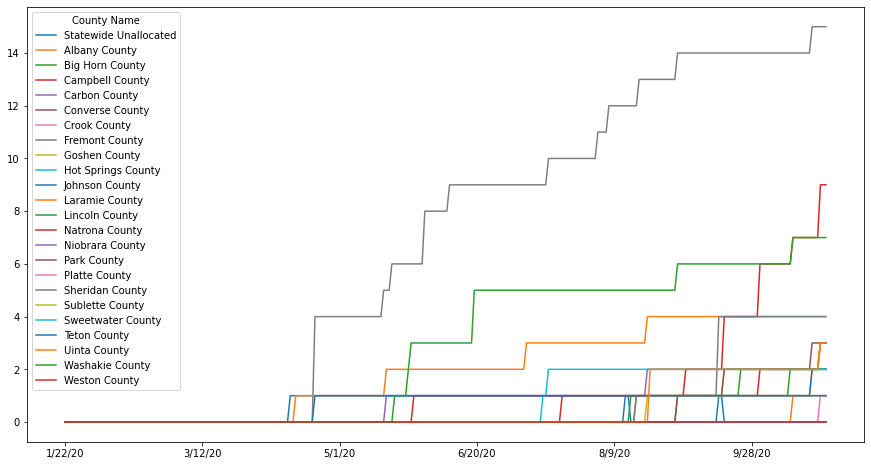

In [11]:
# deaths_by_state -> None
# Takes a state and generates a line graph that shows the number of deaths for each
# county in that state over the entire date range.
def deaths_by_state(state):
    graphing_df = deaths_df.copy()
    graphing_df = graphing_df.set_index('County Name')
    graphing_df = graphing_df.loc[graphing_df['State'] == state]
    graphing_df = graphing_df.drop(columns=graphing_df.columns[[0,1,2]])
    
    for column in graphing_df:
        graphing_df[column] = graphing_df[column].astype(int)
        
    graphing_df.transpose().plot(figsize=(15,8))
    
deaths_by_state('WY')

## Model Training

In [12]:
# test_dataframe -> DataFrame
# This is a modification of the master_dataframe function that creates the same dataframe
# for the instances within the state of Vermont. This returned dataframe is used for testing
# since the master_dataframe is very large and often crashes our Jupyter notebooks.
def test_dataframe():
    c_df = cases_df.copy().iloc[:,:-7]
    d_df = deaths_df.copy().iloc[:,:-7]
    n_c_df = new_cases_df.copy().iloc[:,:-7]
    n_d_df = new_deaths_df.copy().iloc[:,:-7]
    
    dates = []
    counties = []
    populations = []
    total_cases = []
    new_cases = []
    total_deaths = []
    new_deaths = []
    num_cases_in_seven_days = []
    ignored_columns = [0, 1, 2, 3]
    
    row_index = 0
    for index, row in c_df.iterrows():
        if row['State'] == 'VT':
            countyFIPS = c_df.at[index, c_df.columns[0]]
            if countyFIPS in pops_df['ï»¿countyFIPS']:
                population = pops_df.loc[pops_df['ï»¿countyFIPS'] == countyFIPS, 'population'].iloc[0]
            else:
                population = 0

            for col_idx in range(len(c_df.columns)):
                if col_idx not in ignored_columns:
                    date = cases_df.columns[col_idx]
                    dates.append(date)
                    counties.append(countyFIPS)
                    populations.append(population)
                    total_cases.append(c_df.iloc[int(row_index)][date])
                    new_cases.append(n_c_df.iloc[int(row_index)][date])
                    total_deaths.append(d_df.iloc[int(row_index)][date])
                    new_deaths.append(n_d_df.iloc[int(row_index)][date])
                    num_cases_in_seven_days.append(cases_df.iloc[int(row_index)][cases_df.columns[col_idx + 7]])
            row_index += 1
        
    df = pd.DataFrame(list(zip(counties, populations, total_cases, new_cases, total_deaths, new_deaths, num_cases_in_seven_days)), 
                      index = dates, 
                      columns = ['CountyFIPS', 'Population', 'Total Cases', 'New Cases', 'Total Deaths', 'New Deaths', 'Cases in 7 Days'])
    return df
    
test_df = test_dataframe()
test_df

,CountyFIPS,Population,Total Cases,New Cases,Total Deaths,New Deaths,Cases in 7 Days
1/22/20,50001,36777,0,0,0,0,0
1/23/20,50001,36777,0,0,0,0,0
1/24/20,50001,36777,0,0,0,0,0
1/25/20,50001,36777,0,0,0,0,0
1/26/20,50001,36777,0,0,0,0,0
...,...,...,...,...,...,...,...
10/14/20,50027,55062,1229,6,16,0,1273
10/15/20,50027,55062,1236,7,16,0,1300
10/16/20,50027,55062,1240,4,16,0,1336
10/17/20,50027,55062,1259,19,16,0,1343


In [13]:
# remove unnecessary column for Decision Tree (CountyFIPS)
test_df = test_df.drop('CountyFIPS', axis=1)

# split dataframe into X and Y
cols = test_df.shape[1]
X = test_df.iloc[:,0:cols-1]
Y = test_df.iloc[:,cols-1:cols]

# split X and Y into training and testing dataframes
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [14]:
# Create a decision tree object and fit it to our training data
dtree = DecisionTreeRegressor(max_depth=20, min_samples_leaf=0.01, random_state=3)
dtree.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=0.01, random_state=3)

## Model evaluation

In [15]:
# Predict using our training and test data, and output the RMSE and R^2 values.
# Expected - low RMSE, high R^2 percentage value.
pred_train_tree= dtree.predict(X_train)
print(np.sqrt(mean_squared_error(Y_train, pred_train_tree)))
print(r2_score(Y_train, pred_train_tree))

pred_test_tree= dtree.predict(X_test)
print(np.sqrt(mean_squared_error(Y_test, pred_test_tree))) 
print(r2_score(Y_test, pred_test_tree))

112.35650806914387
0.9863230430565834
98.12464767139535
0.9847062509501345


## Hyperparameter Tuning

In [223]:
# Using a grid search to tune our hyperparameters
grid_search_params = {
    'max_depth': [1,3,4,5,6,8,10,20,30],
    'min_samples_leaf': [.001, .01, .1, 1],
    'random_state': [1,2,3,4,5],
    'max_leaf_nodes': [5,10,15,20]
}

gridSearchCVForDecTreeReg = GridSearchCV(dtree, grid_search_params, cv = 5)
gridSearchCVForDecTreeReg.fit(X,Y)
print("best parameters are ", gridSearchCVForDecTreeReg.best_params_)

best parameters are  {'max_depth': 5, 'max_leaf_nodes': 20, 'min_samples_leaf': 0.001, 'random_state': 4}


## Graphs